O Walmart é uma rede de hipermercados muito famosa por estar presente em 27 países diferentes, com mais de 11 mil lojas. Deixou de atuar no Brasil em 2019 mas, continua atuando fortemente em outros países. Nesse estudo, o Walmart traz uma combinação de dados de 45 lojas incluindo informações de vendas mensais. O Walmart tenta encontrar o impacto de feriados nas vendas das lojas. Os feriados  incluídos nos dados são: Natal, Ação de Graças, Super Bowl, e dia do Trabalho. 

O objetivo desta análise é predizer as vendas das lojas de uma semana. Como há datas, vou analisar se as vendas são impactadas por fatores baseados no tempo. E a pergunta que norteia esse estudo será: como a inclusão de feriados em uma semana aumenta as vendas nas lojas? 

### Importando bibliotecas e dados

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

# Date-time
import math
from datetime import datetime
from datetime import timedelta

# Plotagem/Plotting
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Lendo os arquivos e armazenando em dataframes
#### Reading files and storing in dataframes

In [4]:
df_store = pd.read_csv('./Data/stores.csv')

In [5]:
df_train = pd.read_csv('./Data/train.csv')

In [6]:
df_features = pd.read_csv('./Data/features.csv')

In [7]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
# Concatenando os 3 diferentes datasets
# Merge 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [11]:
# Removendo coluna duplicada: o uso de inplace significa que estamos sobrescrevendo o dataframe
# Removing duplicated column: Use of inplace means we're overwriting the dataframe
df.drop(['IsHoliday_y'], axis = 1, inplace=True)

In [12]:
#Renomeando a coluna
#Renaming the column
df.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace = True)

In [13]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [14]:
#Verifying if dataframe is not corrupted after changes made.
# This function shows (rows,columns)
df.shape 

(421570, 16)

### Lojas e Números de Departamentos
#### Store & Department numbers

In [15]:
# Número de valores distintos
# Number of different values
df['Store'].nunique()

45

In [16]:
df['Dept'].nunique()

81

PT
Agora, eu verifico as médias de vendas semanais para cada loja e departamento a fim de observar valores divergentes para o cenário. 

EN
Now, I check the weekly sales averages for each store and department to observe divergent values for the scenario.

In [17]:
store_dept_table = pd.pivot_table(df,index='Store', columns='Dept', values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [18]:
output = df['Dept'].unique()
print(sorted(output))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


PT
O número das lojas vão de 1 até 45, enquanto o número dos departamentos vão de 1 a 99, mas é possível notar que há alguns valores faltantes como 86, 88, e 89. O número total de departamentos deve ser, portanto, 81.

É possível ver, a partir da tabela pivot, que há médias zeradas e médias negativas. Nesse cenário,é impossível que uma loja/departamento não venda absolutamente nada em uma semana. Os valores 0 e valores negativos não podem aparecer. Logo, será necessário alterar tais valores.

EN
The number of stores ranges from 1 to 45, while the number of departments ranges from 1 to 99, but it is possible to notice that there are some missing values such as 86, 88, and 89. The total number of departments must therefore be 81.

It is possible to see, from the pivot table, that there are zero averages and negative averages. In this scenario, it is impossible for a store/department to sell absolutely nothing in a week. 0 values ​​and negative values ​​cannot appear. Therefore, it will be necessary to change these values.

In [19]:
df.loc[df['Weekly_Sales'] <= 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


PT
Como 1358 linhas representam somente 0,3% do total de linhas (421570), é passível remover tais linhas que contém valores errados de vendas.

EN
Since 1,358 rows represent only 0.3% of the total number of rows (421570), it is possible to remove those rows that contain wrong sales values.

In [20]:
df = df.loc[df['Weekly_Sales'] > 0]

In [21]:
df.shape

(420212, 16)

### Datas
#### Dates

In [22]:
df['Date'].head(5).append(df['Date'].tail(5))

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

PT
Nossos dados vão de 5 de Fevereiro de 2010 a 26 de outubro de 2012

EN
Our data is from February 5, 2010 to October 26, 2012

### Coluna 'isHoliday'
#### 'IsHoliday' column

In [23]:
df_holiday = df.loc[df['IsHoliday'] == True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [24]:
df_not_holiday = df.loc[df['IsHoliday'] == False]
df_not_holiday['Date'].nunique()

133

**PT**
Nem todos os feriados estão nos dados. Sendo eles:

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Após 07 de setembro de 2012, os feriados estão na base de teste para previsão. **Quando analisamos os dados, a média de vendas semanais nos feriados é significativamente maior do que nos dias sem feriados**. Nos dados de teste, há 133 semanas sem feriados e 10 semanas com feriados.

Quero ver diferenças entre os tipos de feriados. Então, criei novas colunas para os 4 tipos de feriados e as preencho com valores booleanos. Se a data pertencer a este tipo de feriado, será Verdadeira, se não Falso.

**EN**
All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [25]:
# Datas do Super Bowl na base de teste
# Super Bowl in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [26]:
# Datas do Dia do trabalho na base de teste
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [27]:
# Datas de Ações de Graças na base de teste
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [28]:
# Datas de Natal na base de teste
# Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

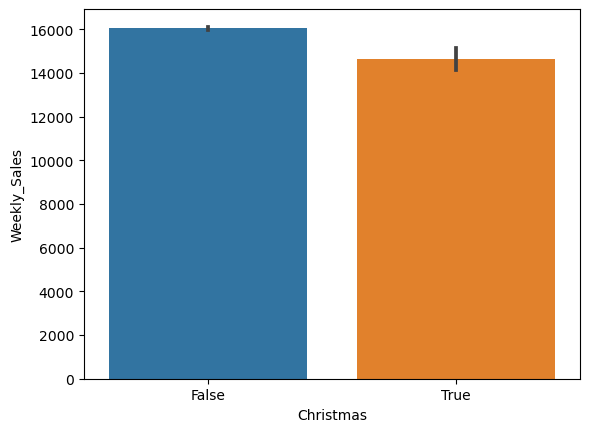

In [29]:
# Feriado de Natal vs não feriado de Natal
# Christmas holiday vs not-Christmas
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) 

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

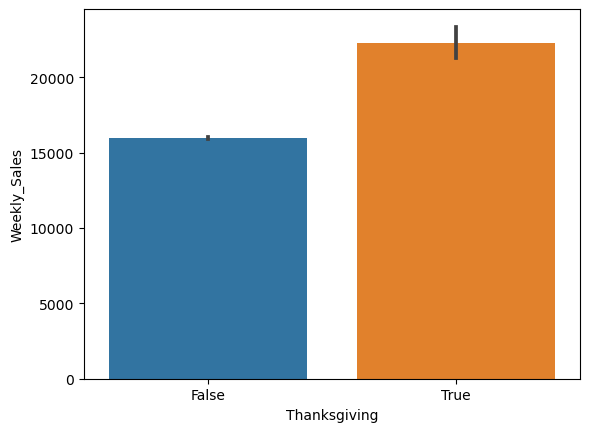

In [30]:
# Feriado de Ações de Graças VS Não feriado de Ações de Graças
# Thanksgiving holiday vs not-thanksgiving
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) 

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

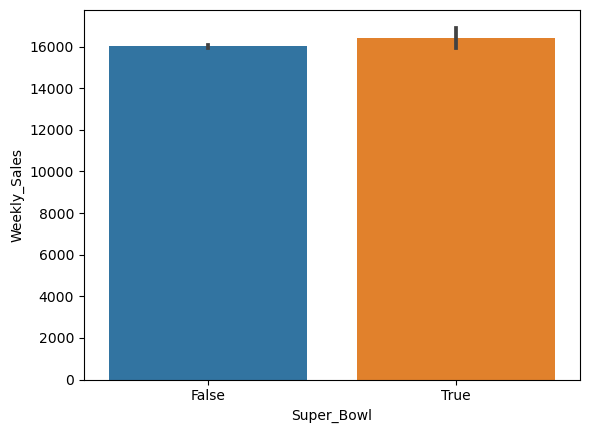

In [31]:
# Feriado Super Bowl VS Não feriado Super Bowl
# Super bowl holiday vs not-super bowl
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) 

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

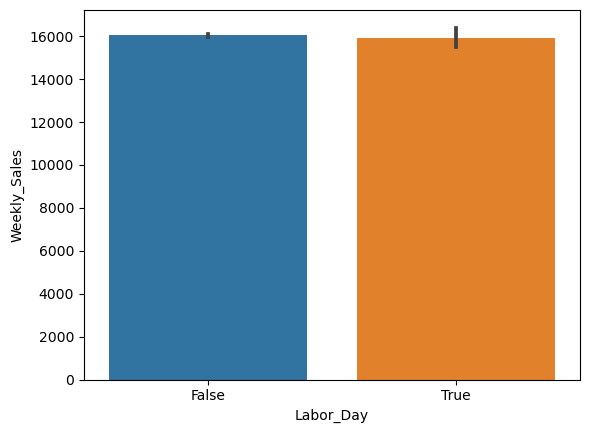

In [32]:
# Feriado Dia do trabalho VS Não Feriado Dia do Trabalho
# Labor day holiday vs not-labor day
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) 

**PT**
É possível ver que, pelos gráficos, o Dia do Trabalho e o Natal não aumentam as vendas médias semanais. Há um efeito positivo nas vendas no Super Bowl, mas a maior diferença está no Dia de Ação de Graças. Podemos inferir que as pessoas geralmente preferem comprar presentes de Natal em um curto período de tempo pré-Natal, então isso pode contribuir para que não se altere as vendas na semana de Natal. Na semana de Ação de Graças há vendas da Black Friday.

**EN**
It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

### Analisando os tipos de dados
#### Analyzing data type

**PT**
Podemos ver três tipos diferentes de lojas nos dados: A, B e C.

**EN**
There are three different store types in the data as A, B and C.

In [33]:
# Média de vendas para cada tipo no feriado de Natal 
# Avg weekly sales for types on Christmas 
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [34]:
# Média de vendas para cada tipo no feriado do Dia do Trabalho
# Avg weekly sales for types on feriado do Dia do Trabalho
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [35]:
# Média de vendas para cada tipo no feriado do Dia de Ações de Graças
# Avg weekly sales for types on Thanksgiving
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [36]:
# Média de vendas para cada tipo no feriado do Super Bowl
# Avg weekly sales for types on Super Bowl
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

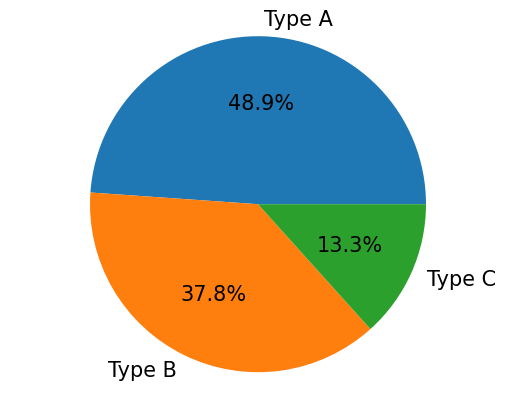

In [37]:
# Plotando o percentual dos tipos de lojas
# Ploting percentages of store types
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

É possível ver que metade das lojas percetem ao grupo Tipo A.

It's possible to see that half of the stores are belongs to Type A group.

In [38]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

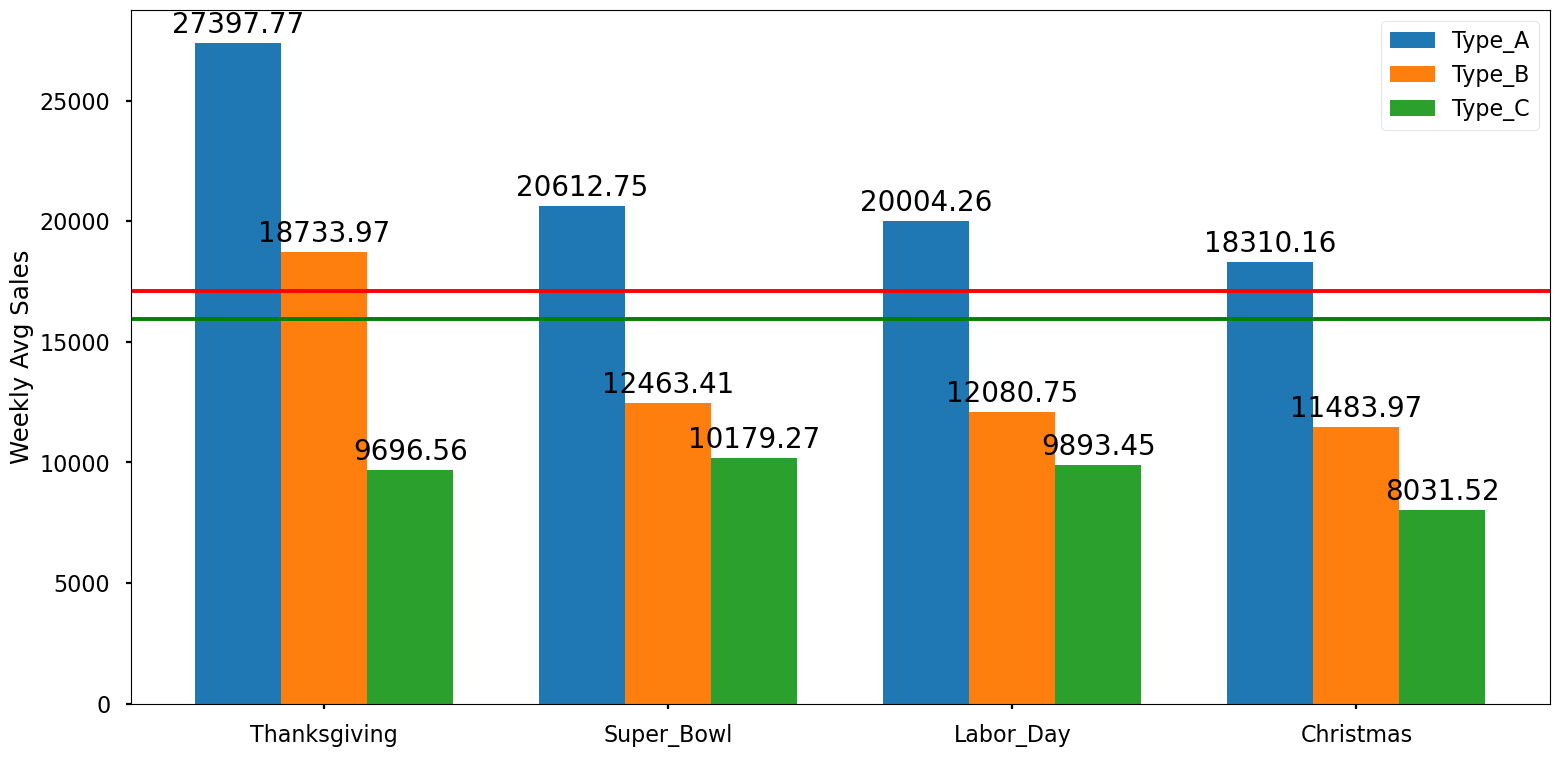

In [39]:
# Plotando média semanal de vendas de acordo com os feriados
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

Observa-se no gráfico que a maior média de vendas ocorre na semana de Ação de Graças, entre os feriados. E, em todos os feriados, as lojas Tipo A têm as vendas mais altas.

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [40]:
# Ordenando por vendas semanais
# Order by Weekly Sales
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Além disso, não é surpresa que as 5 maiores vendas semanais pertençam às semanas de Ação de Graças.

Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

### Analisando a relação Tamanho e Tipo (Size and Type)
#### Analyzing the Size - Type Relation

In [41]:
# Olhando a relação Size - Type
# See the Size-Type relation
df_store.groupby('Type').describe()['Size'].round(2) 

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


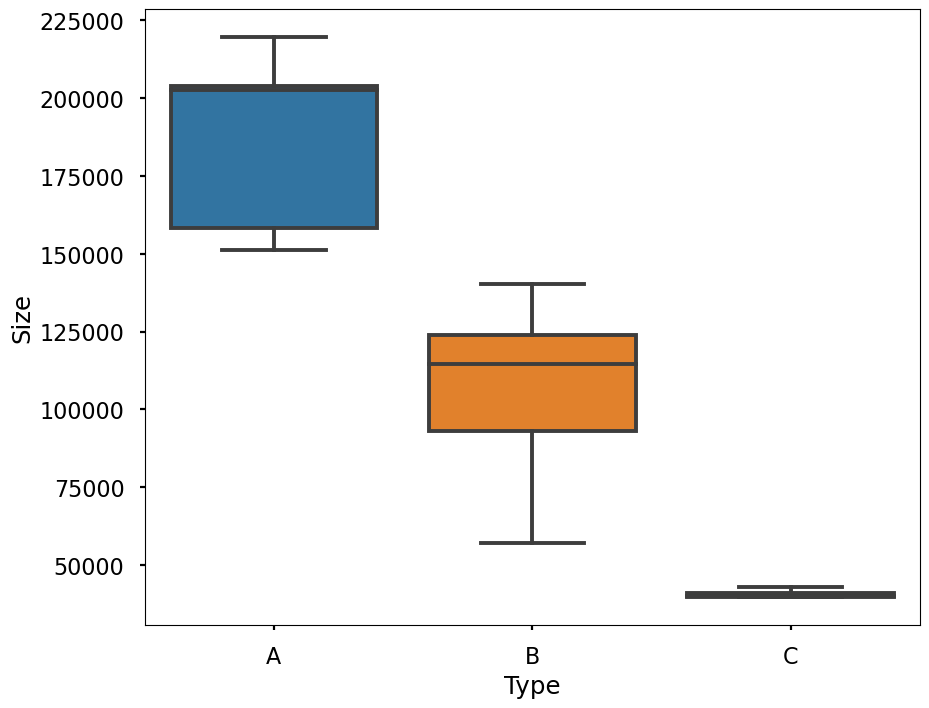

In [42]:
plt.figure(figsize=(10,8)) 
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

O tamanho do tipo de loja é consistente com as vendas, conforme esperado. Lojas de maior porte apresentam vendas maiores. E o Walmart classifica as lojas de acordo com seus tamanhos conforme gráfico. Após o menor valor de tamanho do Tipo A, o Tipo B começa. Após o menor valor de tamanho do Tipo B, o Tipo C começa.

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

### Markdown Columns

O Walmart forneceu colunas de remarcações para ver o efeito das remarcações nas vendas. Quando verifico as colunas, há muitos valores NaN para remarcações. Resolvi trocá-los por 0, pois se houver remarcação na linha, ela é mostrada com números. Então, se eu puder escrever 0, isso mostra que não há remarcação naquela data.

Walmart gave markdown columns to see the effect if markdowns on sales. When I check columns, there are many NaN values for markdowns. I decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if I can write 0, it shows there is no markdown at that date.

In [43]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [44]:
# Preenchendo nulos com 0
# Filling null's with 0
df = df.fillna(0) 

In [45]:
# Checando valores
# Cheking values
df.isna().sum() 

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [46]:
# Analisando algumas estatísticas descritivas
# Analyzing some descriptive statistics
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


O valor mínimo para vendas semanais é 0,01. Muito provavelmente, este valor não é verdadeiro, mas prefiro não alterá-los agora. Porque existem muitos departamentos e muitas lojas. Demora muito tempo para verificar cada departamento de cada loja (45 lojas para 81 departamentos). Então, eu pego médias para EDA.

Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA.

### Análise profunda nas Vendas
#### Deep analysis in Sales

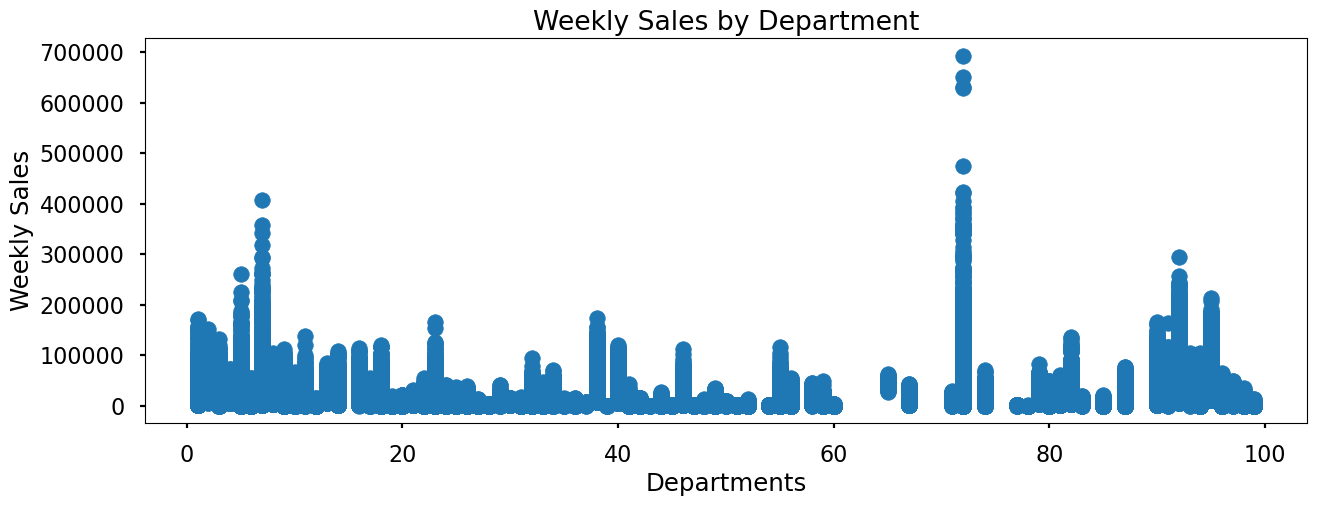

In [47]:
# Gráfico de Vendas mensais por Departamento
# Weekly Sales by Department graphic
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

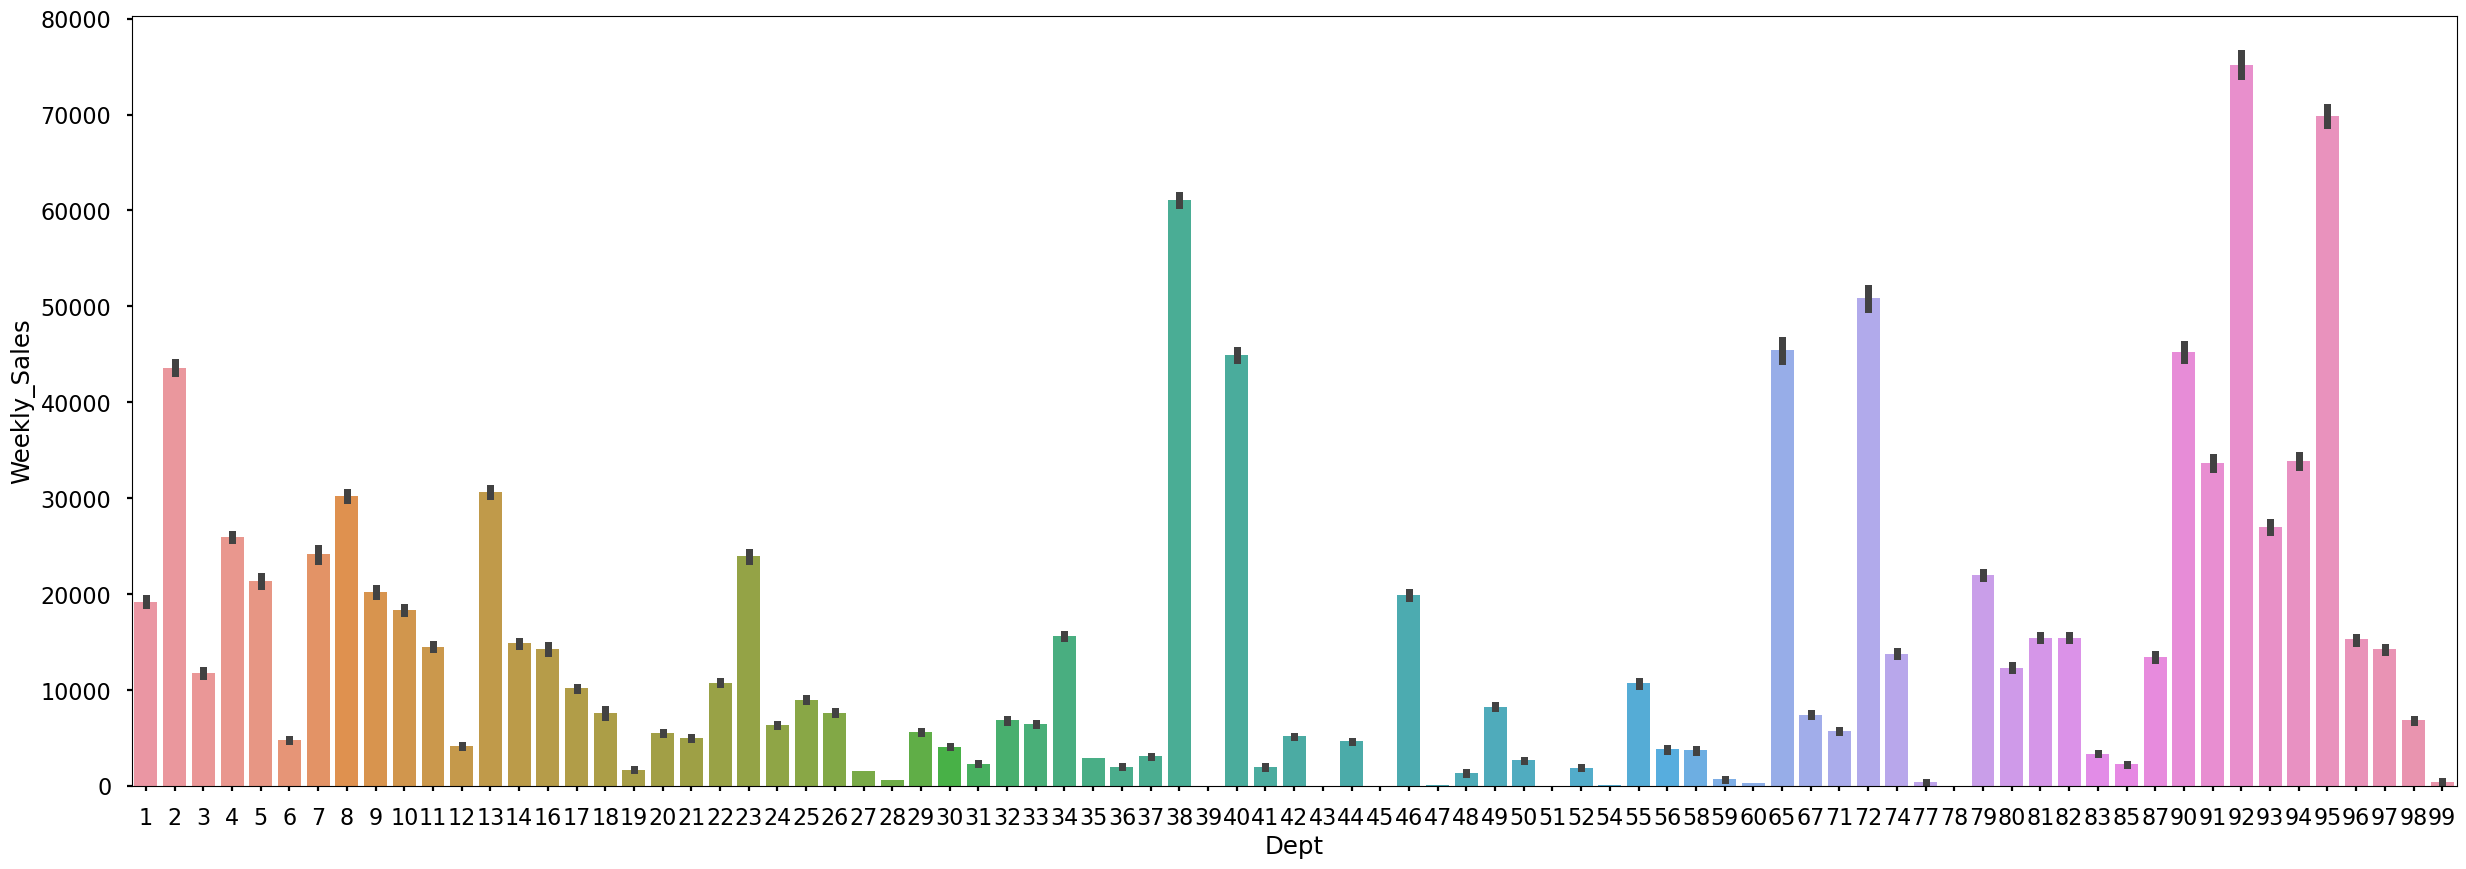

In [48]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

PT: O departamento 72 apresenta vendas sazonais com picos, mas, em média, o departamento 92 tem as vendas mais altas.

EN: Department 72 has seasonal sales peaks, but on average, department 92 has higher sales.

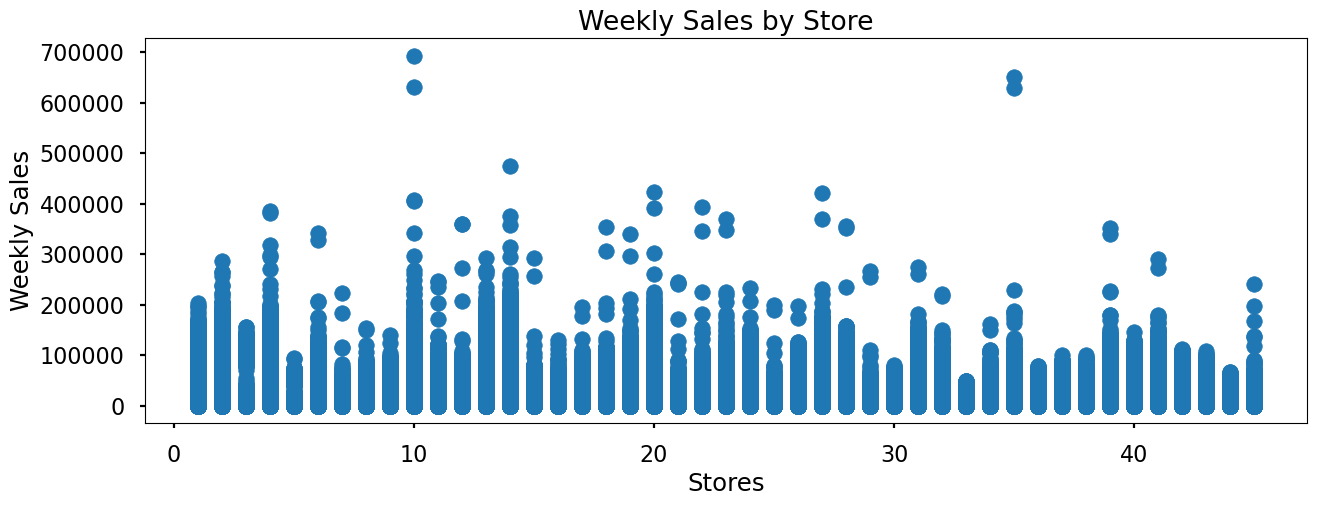

In [49]:
# Vendas semanais por Loja
# Weekly Sales by Store
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

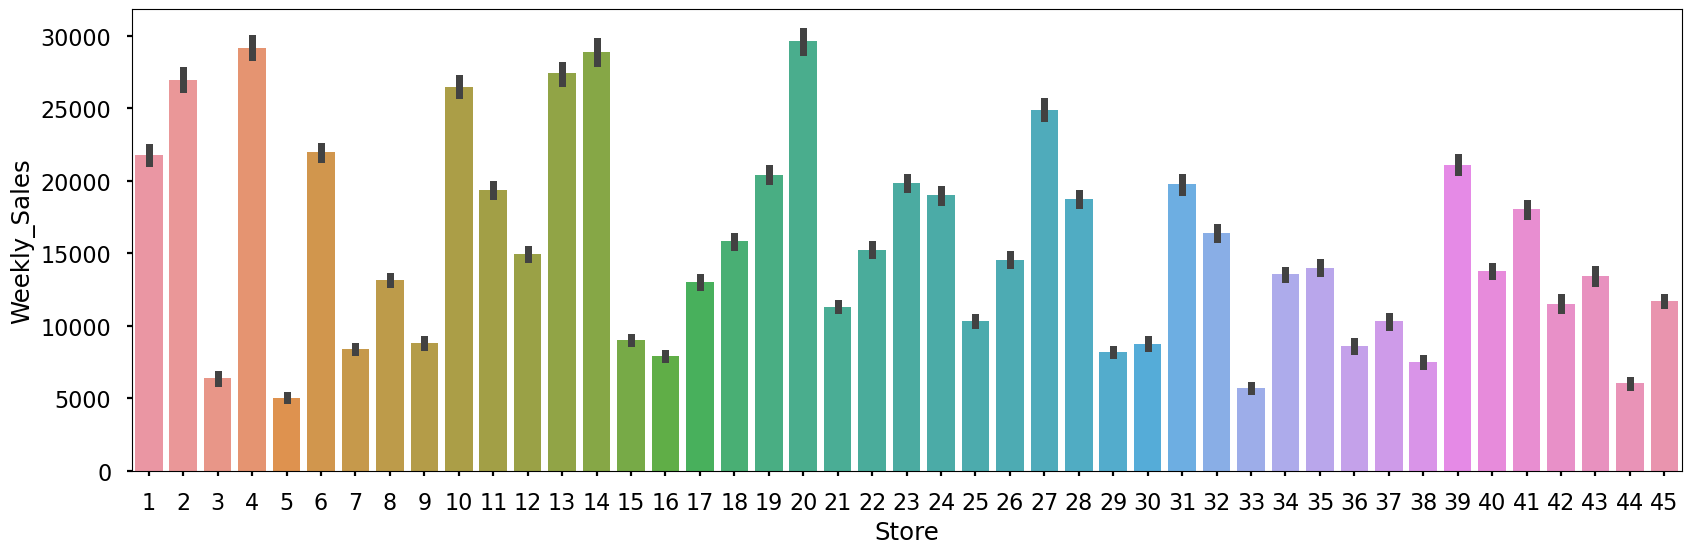

In [50]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

PT: O mesmo ocorre em lojas. A partir do primeiro gráfico, algumas lojas têm vendas mais altas, mas, em média, a loja 20 é a melhor, com as lojas 4 e 14 logo atrás.

EN: The same happens in stores. From the first graph, some stores have higher sales, but on average, store 20 is the best, with stores 4 and 14 following closely.

### Alterando campo de data para 'datetime' e criando novas colunas
#### Changing Date to Datetime and Creating New Columns

In [51]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [52]:
df.groupby('month')['Weekly_Sales'].mean() 

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [53]:
# Ver os melhores anos para vendas
# to see the best years for sales
df.groupby('year')['Weekly_Sales'].mean() 

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

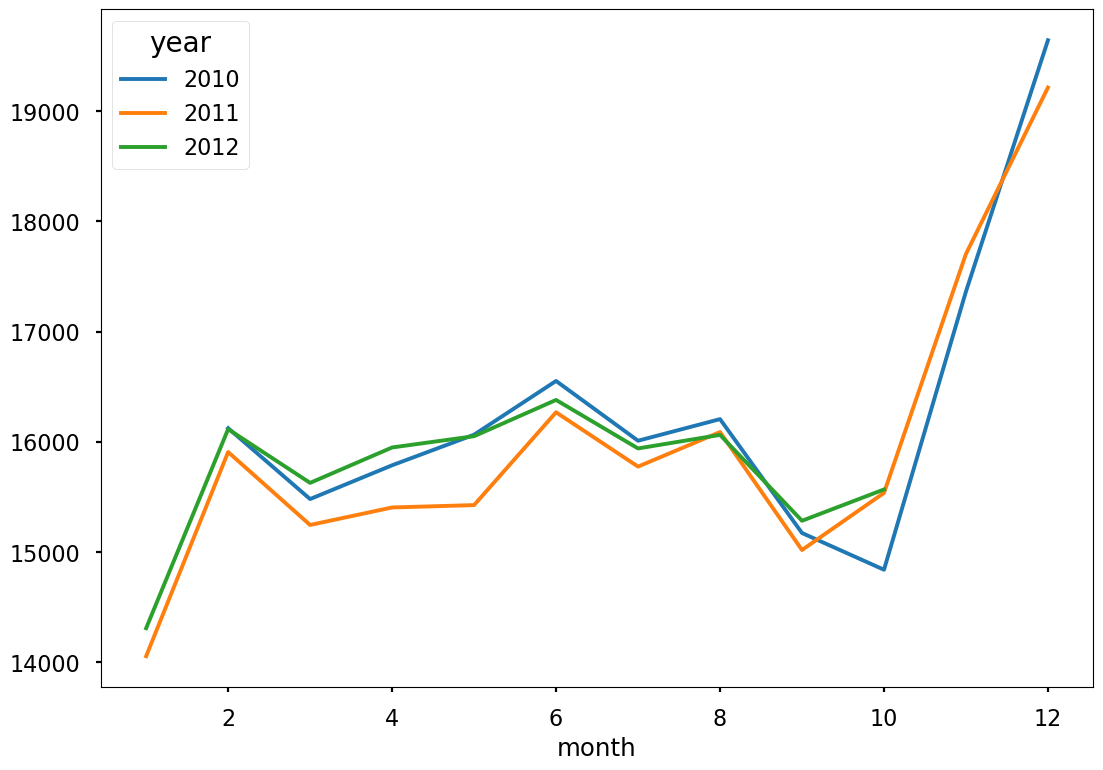

In [54]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

PT: O gráfico mostra que 2011 tem vendas geralmente mais baixas que 2010. Apesar da média de 2010 ser maior, a falta de dados de novembro e dezembro em 2012, meses com vendas elevadas, deixa sua média próxima à de 2010. Provavelmente, 2012 lideraria se obtivermos e adicionarmos os resultados desses meses.

EN: The graph indicates lower sales in 2011 compared to 2010. Despite 2010 having a higher average, the lack of data for November and December in 2012, months with typically higher sales, keeps its average close to that of 2010. It would likely take the lead if we obtain and add the results for those months.

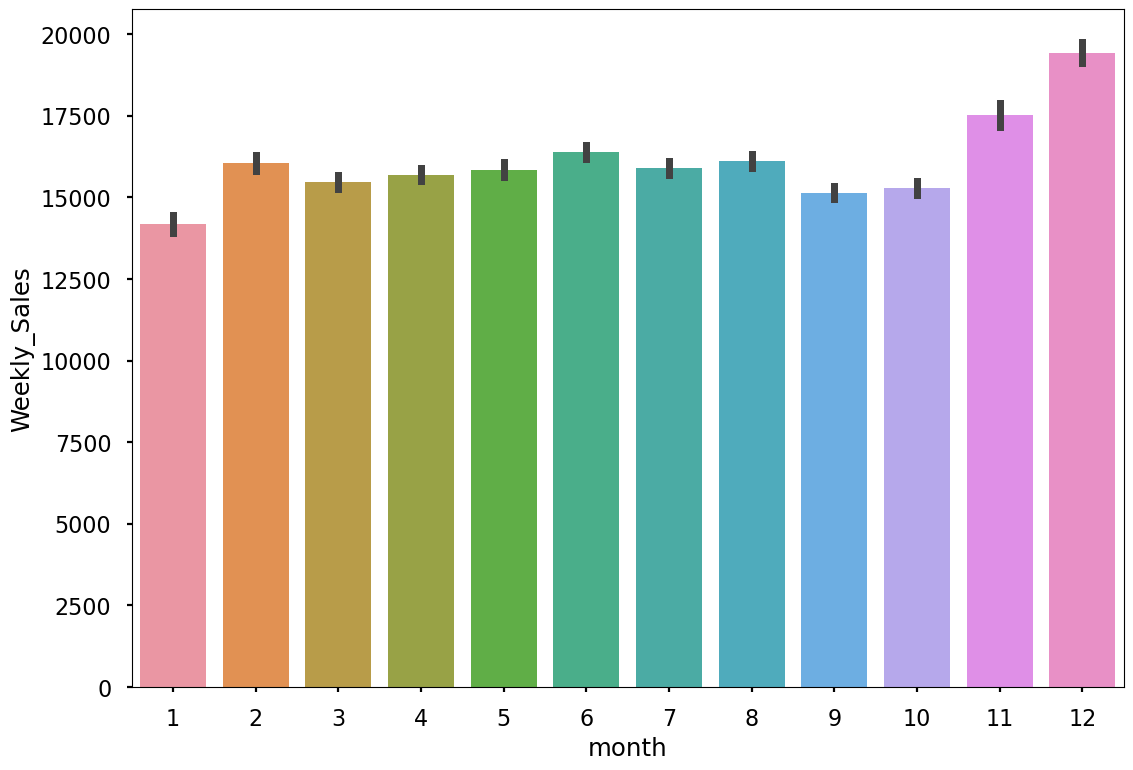

In [55]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

PT: Ao analisar o gráfico acima, as melhores vendas ocorrem em dezembro e novembro, como esperado. Os valores mais altos são associados ao feriado de Ação de Graças, mas, ao calcular a média, fica claro que dezembro tem o melhor valor.

EN: When we look at the graph above, the best sales are in December and November, as expected. The highest values belong to the Thanksgiving holiday, but when we take the average, it is obvious that December has the best value.

In [56]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

PT: As cinco maiores médias de vendas por semana ocorrem 1-2 semanas antes do Natal, do Dia de Ação de Graças, da Black Friday e no final de maio, quando as escolas estão fechadas.
    
EN: The top 5 sales averages by week occur 1-2 weeks before Christmas, Thanksgiving, Black Friday, and at the end of May when schools are closed.

<Axes: xlabel='week'>

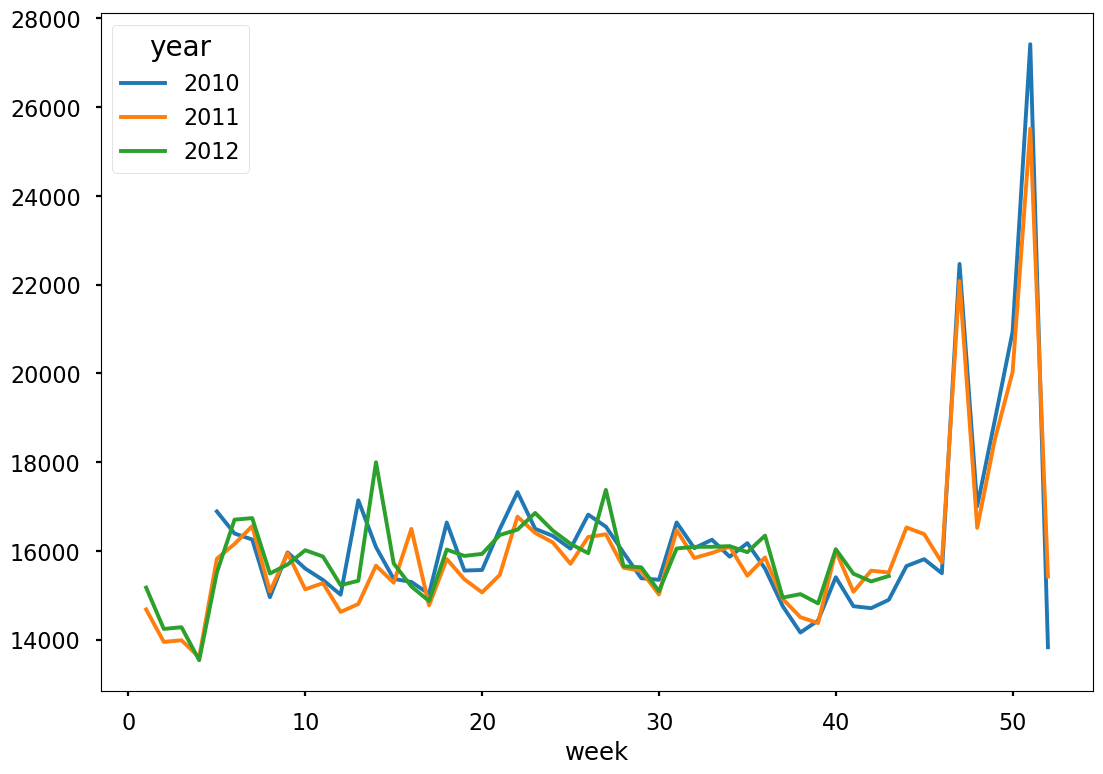

In [57]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

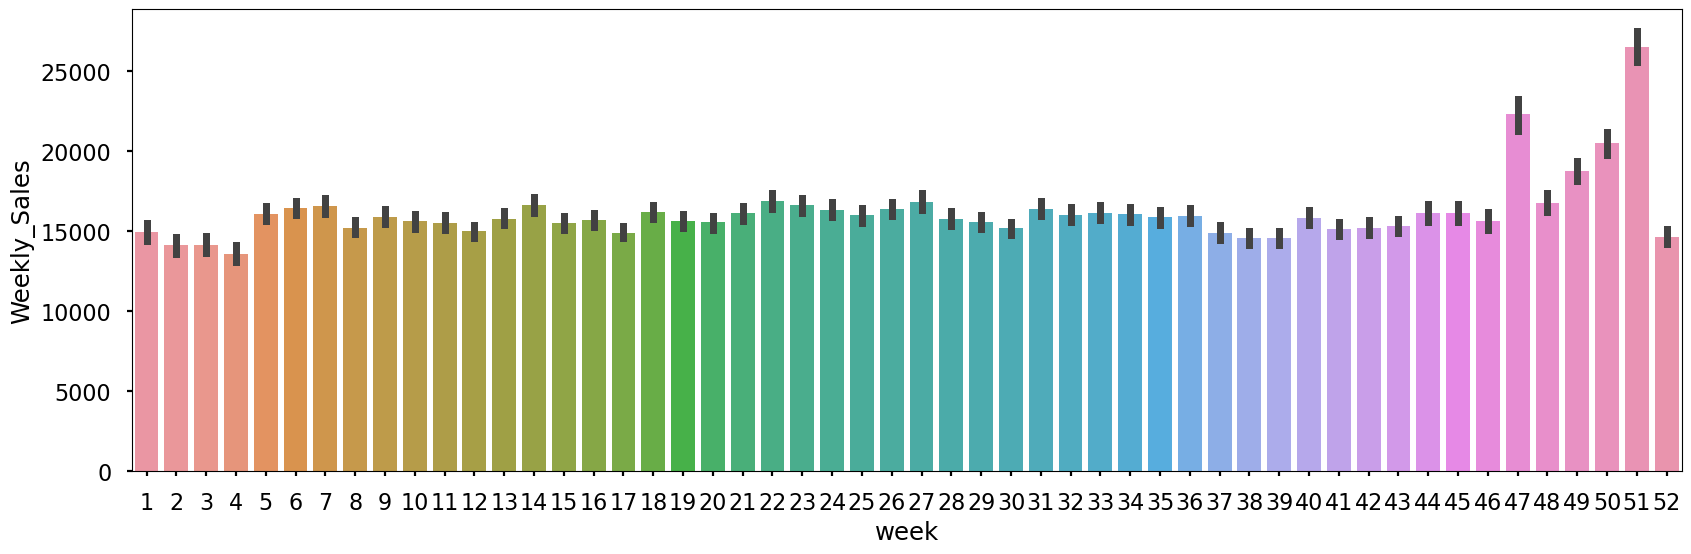

In [58]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

PT: Pelos gráficos, observa-se que a 51ª semana e a 47ª semana têm médias significativamente mais altas devido aos efeitos do Natal, Ação de Graças e Black Friday.

EN: From the graphs, it is evident that the 51st week and 47th weeks have significantly higher averages due to the effects of Christmas, Thanksgiving, and Black Friday.

### Mais análises: Preço do Combustível, IPC (Índice de Preços ao Consumidor), Desemprego, Efeitos da Temperatura

#### Further analysis: Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

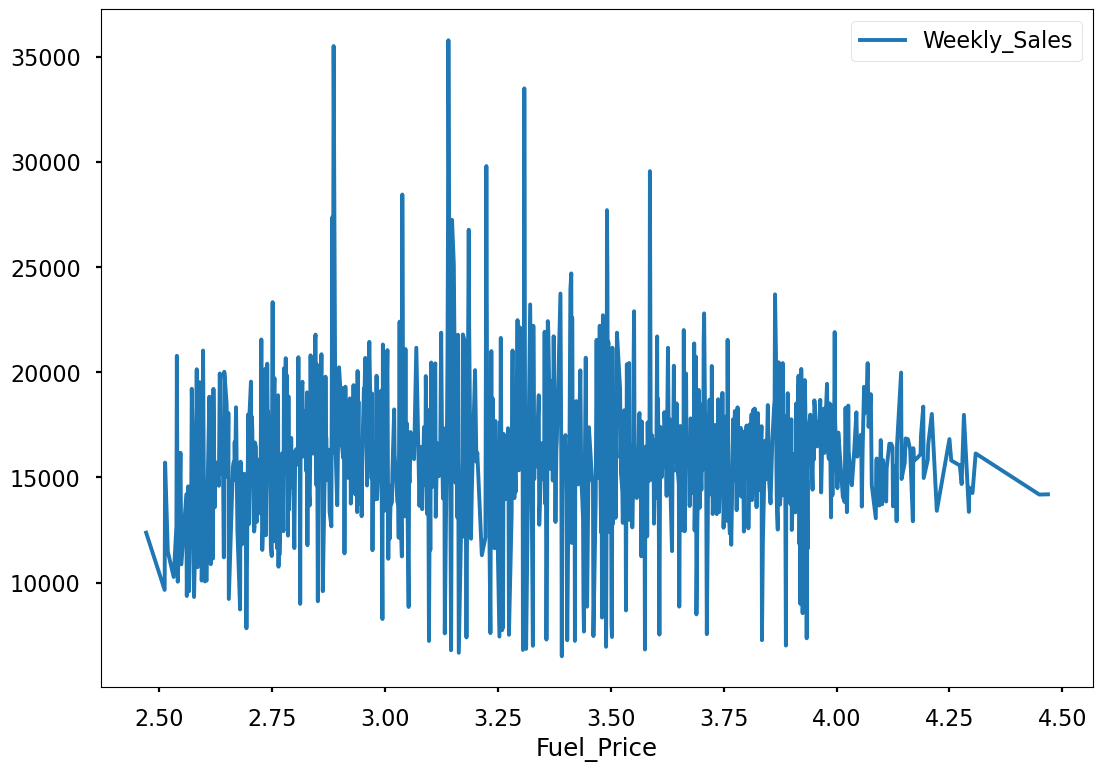

In [59]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

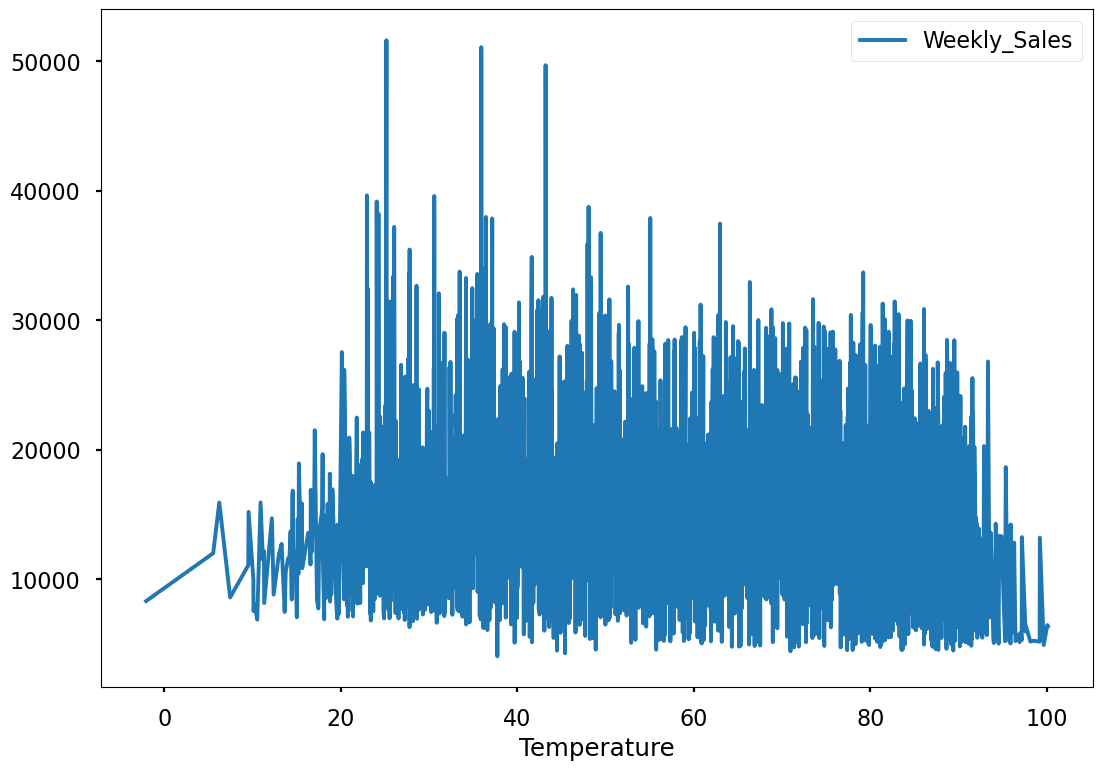

In [60]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

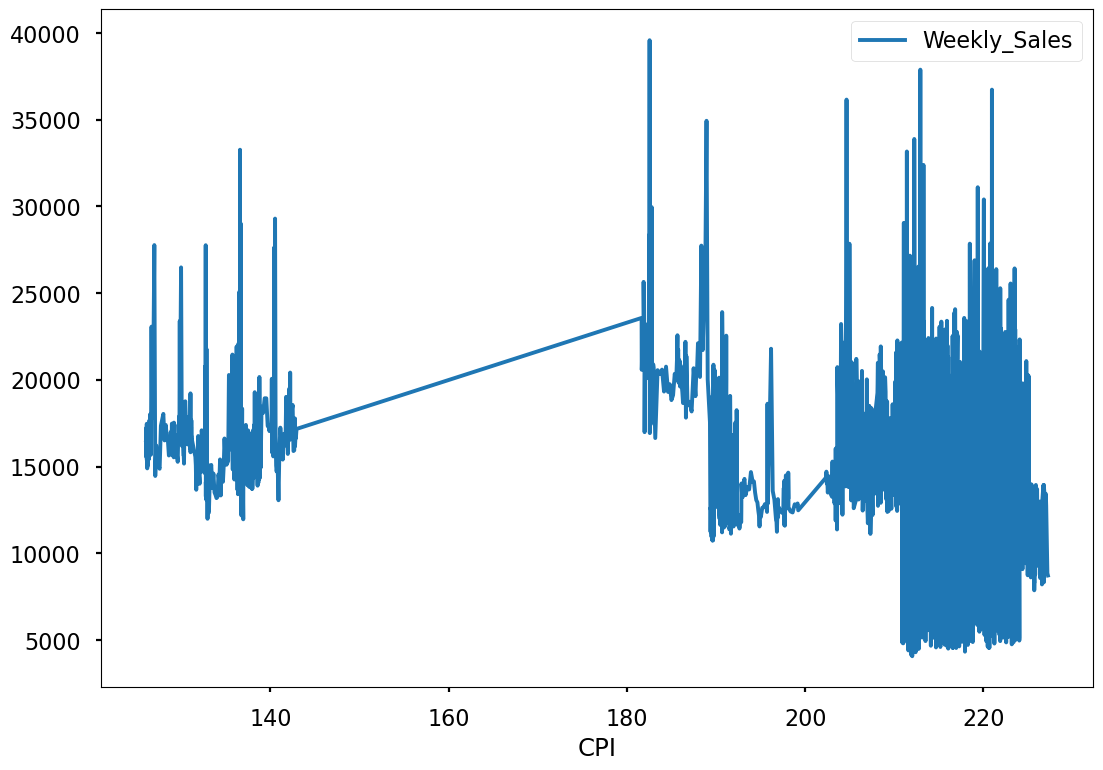

In [61]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

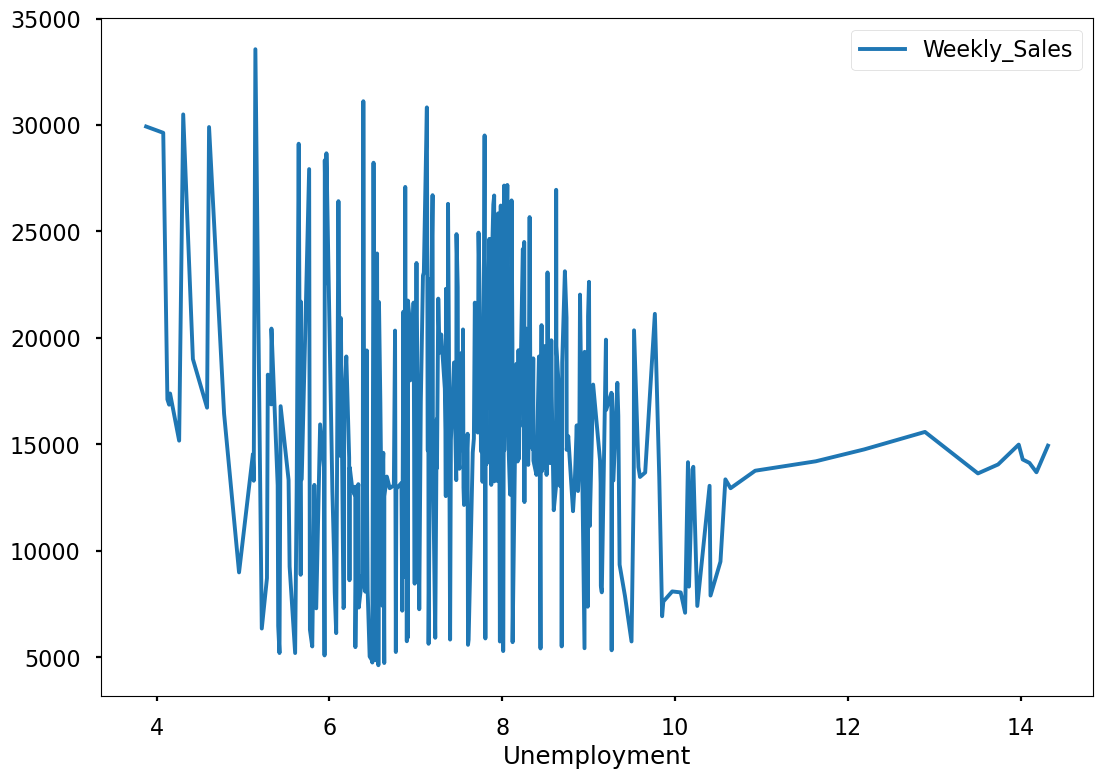

In [62]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

PT: "A partir dos gráficos, observa-se que não há padrões significativos entre IPC, temperatura, taxa de desemprego, preço do combustível em relação às vendas semanais. Não há dados para o IPC entre 140-180 também."

EN: "From the graphs, it is observed that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 as well."

In [63]:
# df.to_csv('clean_data.csv') 